In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510])>

In [2]:
# Opening the dataframe and setting the index
Univariate_data = pd.read_csv('Univariate_Labeled.csv', parse_dates=['DateTime'])
Univariate_data['DayOfWeek'] = Univariate_data['DateTime'].dt.day_of_week # Introducing the day of the week
Univariate_data.drop(columns='DateTime', inplace=True) # Removing DateTime (we have the day of the week)
Univariate_data = Univariate_data[0:34944] # 52 weeks
Univariate_data

,Consumption,Anomaly,DayOfWeek
0,950.0,0,2
1,939.0,0,2
2,943.0,0,2
3,971.0,0,2
4,1014.0,0,2
...,...,...,...
34939,886.0,0,1
34940,883.0,0,1
34941,868.0,0,1
34942,872.0,0,1


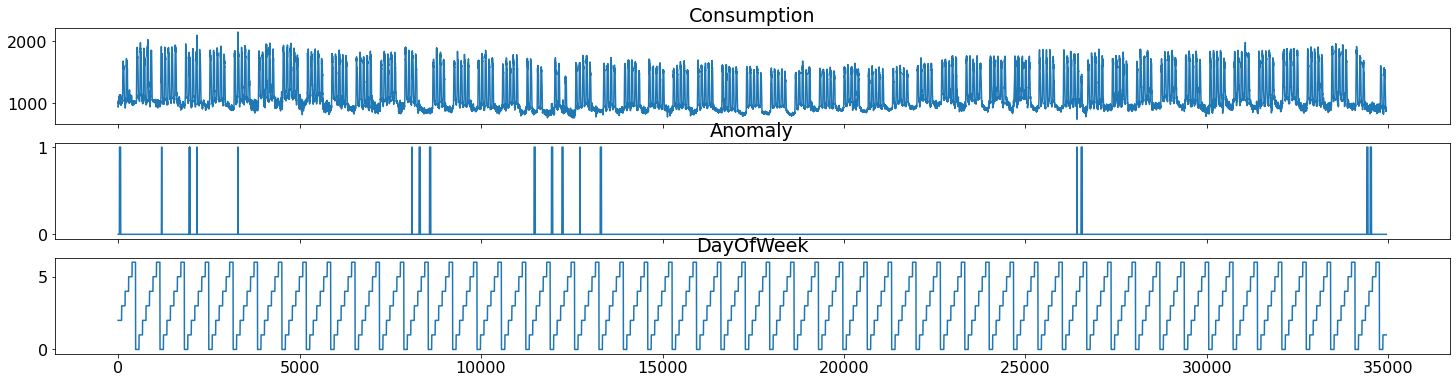

In [3]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [4]:
# Columns used for the following split in train, test and validation sets
Univariate_data['Test'] = 0
Univariate_data['Validation'] = 0
Univariate_data['Train_P1'] = 0
Univariate_data['Train_P2'] = 0
Univariate_data['Train_P3'] = 0
Univariate_data

,Consumption,Anomaly,DayOfWeek,Test,Validation,Train_P1,Train_P2,Train_P3
0,950.0,0,2,0,0,0,0,0
1,939.0,0,2,0,0,0,0,0
2,943.0,0,2,0,0,0,0,0
3,971.0,0,2,0,0,0,0,0
4,1014.0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34939,886.0,0,1,0,0,0,0,0
34940,883.0,0,1,0,0,0,0,0
34941,868.0,0,1,0,0,0,0,0
34942,872.0,0,1,0,0,0,0,0


In [5]:
Univariate_data.at[0, 'Anomaly'] = 0
Univariate_data.loc[0]  

Consumption    950.0
Anomaly          0.0
DayOfWeek        2.0
Test             0.0
Validation       0.0
Train_P1         0.0
Train_P2         0.0
Train_P3         0.0
Name: 0, dtype: float64

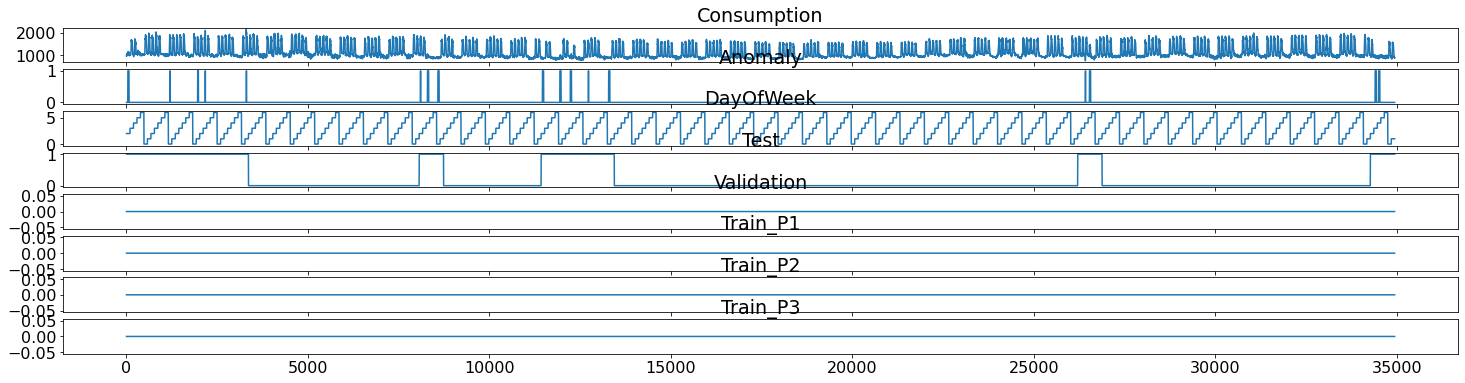

In [6]:
# TEST SET

# Weeks containing anomalies
for i in range (52):
    Slice_Univariate_data = Univariate_data.iloc[(i)*672:(i+1)*672]
    if(Slice_Univariate_data['Anomaly'].sum() != 0):
        for k in range (i*672, (i+1)*672):
            Univariate_data.at[k, 'Test'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

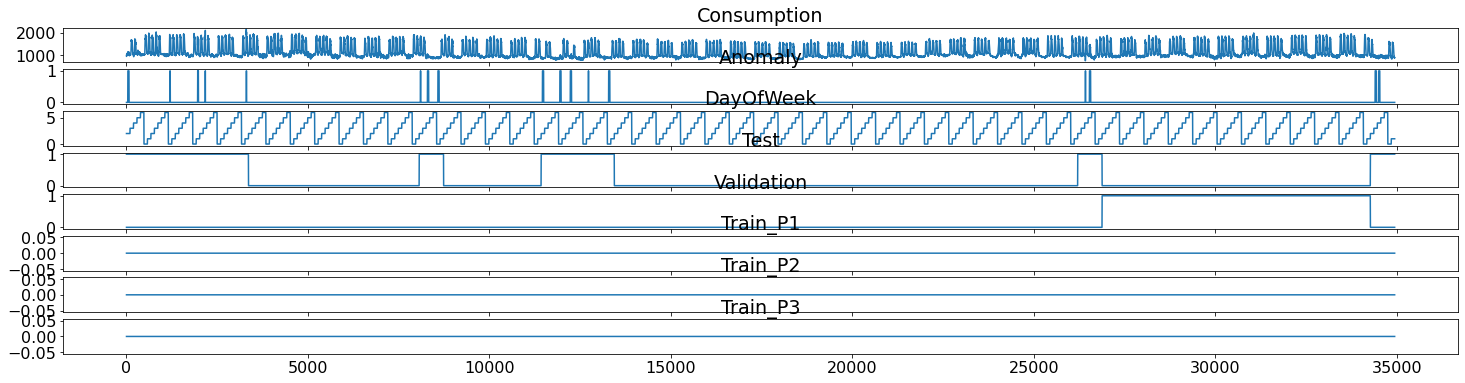

In [7]:
# VALIDATION SET

# Some random weeks
week = [40,41,42,43,44,45,46,47,48,49,50]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Validation'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [8]:
# TRAINING SET

week = [5,6,7,8,9,10,11]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P1'] = 1
    
week = [13,14,15,16]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P2'] = 1
    
week = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P3'] = 1

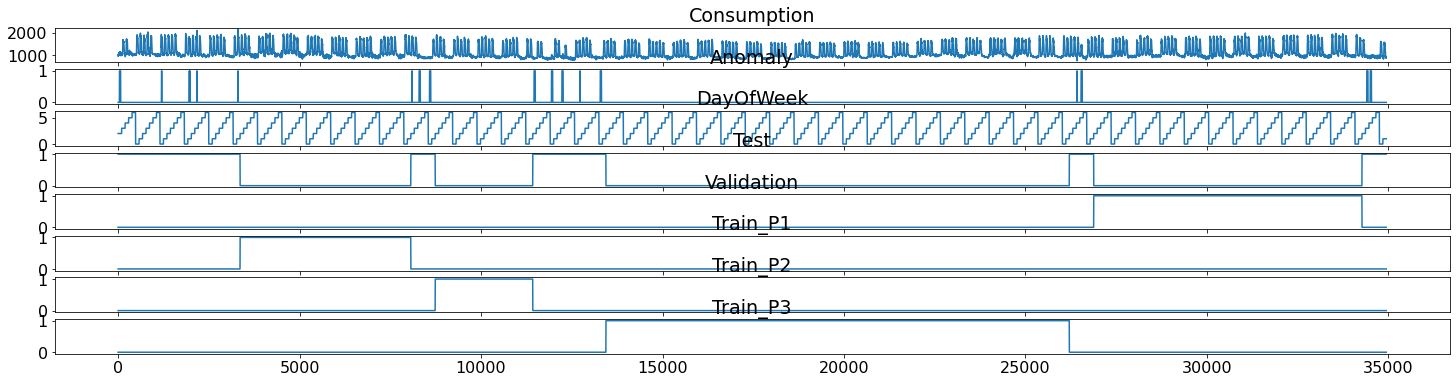

In [9]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [10]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = Univariate_data[Univariate_data['Train_P1']==1].copy()
X_train_temp_P2 = Univariate_data[Univariate_data['Train_P2']==1].copy()
X_train_temp_P3 = Univariate_data[Univariate_data['Train_P3']==1].copy()
X_validation_temp = Univariate_data[Univariate_data['Validation']==1].copy()
X_test_temp = Univariate_data[Univariate_data['Test']==1].copy()

In [11]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly']]
Anomaly_Train_P3 = X_train_temp_P3[['Anomaly']]
Anomaly_Validation = X_validation_temp[['Anomaly']]
Anomaly_Test = X_test_temp[['Anomaly']]

In [12]:
temp = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global = pd.concat([X_train_temp_P3,temp],axis=0)
X_train_temp_global.shape

(20160, 8)

In [13]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_train_raw_P3 = (X_train_temp_P3-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0]+X_train_raw_P3.shape[0] == Univariate_data.shape[0])

Consumption    1136.788542
Anomaly           0.000000
DayOfWeek         3.000000
Test              0.000000
Validation        0.000000
Train_P1          0.233333
Train_P2          0.133333
Train_P3          0.633333
dtype: float64 Consumption    282.830237
Anomaly          0.000000
DayOfWeek        2.000050
Test             0.000000
Validation       0.000000
Train_P1         0.422963
Train_P2         0.339943
Train_P3         0.481906
dtype: float64
True


In [14]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['Consumption', 'DayOfWeek']]
X_train_raw_P2 = X_train_raw_P2[['Consumption', 'DayOfWeek']]
X_train_raw_P3 = X_train_raw_P3[['Consumption', 'DayOfWeek']]
X_validation_raw = X_validation_raw[['Consumption', 'DayOfWeek']]
X_test_raw = X_test_raw[['Consumption', 'DayOfWeek']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_train_raw_P3.shape, X_validation_raw.shape, X_test_raw.shape

((4704, 2), (2688, 2), (12768, 2), (7392, 2), (7392, 2))

In [15]:
X_train_raw_P1.reset_index(inplace=True)
X_train_raw_P1.drop(columns='index', inplace=True)
X_train_raw_P2.reset_index(inplace=True)
X_train_raw_P2.drop(columns='index', inplace=True)
X_train_raw_P3.reset_index(inplace=True)
X_train_raw_P3.drop(columns='index', inplace=True)
X_validation_raw.reset_index(inplace=True)
X_validation_raw.drop(columns='index', inplace=True)
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)

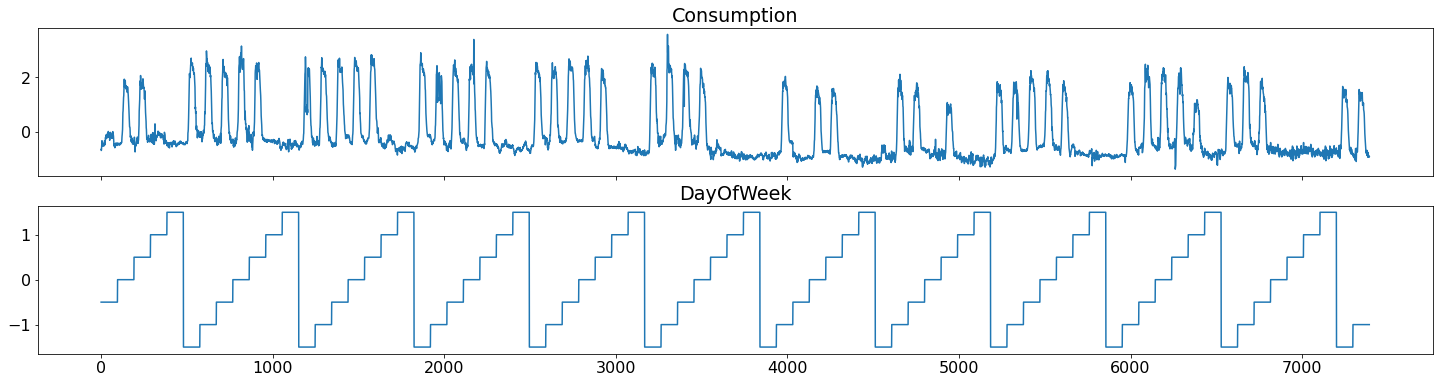

In [16]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training - Preparation

In [17]:
# Training parameters

window = 672       # 1 week
stride = 4         # 1 hour
latent_dim = 10    # Latent dimension - lat_dim = 16 is better !!!
epochs = 300       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
M = 10             # Montecarlo
alpha = 0.5

In [18]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [19]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_train_P3, A_train_P3 = build_sequences(X_train_raw_P3, Anomaly_Train_P3, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape,X_train_P3.shape

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1009, 672, 2), (505, 672, 2), (3025, 672, 2))

In [20]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
X_train = np.concatenate([X_train,X_train_P3],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
A_train = np.concatenate([A_train,A_train_P3],axis=0)
X_train.shape, A_train.shape

((4539, 672, 2), (4539, 672, 1))

In [21]:
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=window) 
X_test.shape

PADDING: 0


(11, 672, 2)

## Building the model + Training

In [22]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [23]:
# Reparametrization trick
def sample(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), seed=seed)
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [24]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

x = tfkl.LSTM(64, return_sequences=False)(encoder_input)

x = tfkl.Dense(latent_dim, activation='linear')(x)

# Latent representation: mean + log of std.dev.
z_mu = tfkl.Dense(latent_dim, name='latent_mu')(x) # Mean
z_log_var = tfkl.Dense(latent_dim, name='latent_log_var')(x) # Log Var 

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample, output_shape=(latent_dim, ), name='z')([z_mu, z_log_var])

encoder = tfk.Model(encoder_input, [z_mu, z_log_var, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 672, 2)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           17152       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 10)           650         ['lstm[0][0]']                   
                                                                                                  
 latent_mu (Dense)              (None, 10)           110         ['dense[0][0]']                  
                                                                                            

In [25]:
# Reparametrization trick
def sample_z2(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [26]:
###########
# DECODER #
###########

decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = tfkl.RepeatVector(window)(decoder_input)
x = tfkl.LSTM(64, return_sequences=True)(x)
x = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(x)

mu = tfkl.Conv1D(X_train.shape[2],2,1, padding='same', name='mu')(x)
log_var = tfkl.Conv1D(X_train.shape[2],2,1, padding='same', name='log_var')(x)

# RECONSTRUCTION FOR THE PLOT (NO TRAINING)
decoder_output = tfkl.Lambda(sample_z2, name='decoder_output')([mu, log_var])

# Define and summarize decoder model
decoder = tfk.Model(decoder_input, [mu, log_var, decoder_output], name='decoder')

decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 672, 10)      0           ['decoder_input[0][0]']          
                                                                                                  
 lstm_1 (LSTM)                  (None, 672, 64)      19200       ['repeat_vector[0][0]']          
                                                                                                  
 time_distributed (TimeDistribu  (None, 672, 2)      130         ['lstm_1[0][0]']                 
 ted)                                                                                       

In [27]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.likelihood_tracker = tfk.metrics.Mean(name="likelihood")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.likelihood_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_tracker
        ]
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            # Reparametrization trick
            def sample_z2(args):
                z_mean, z_log_var = args
                eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
                return z_mean + tf.exp(alpha * z_log_var) * eps
            
            encoder_mu, encoder_log_var, z = self.encoder(data)
            decoder_mu, decoder_log_var, _ = self.decoder(z)
            decoder_sigma = tf.exp(alpha * decoder_log_var)
                             
            pdf_normal = tfp.distributions.MultivariateNormalDiag(decoder_mu, decoder_sigma, validate_args=True, name='Gauss')
            likelihood = -(pdf_normal.log_prob(data))
            likelihood = tf.reduce_mean(likelihood, axis=-1)
            likelihood = tf.reduce_mean(likelihood, axis=-1)
                
            decoder_output = tfkl.Lambda(sample_z2, output_shape=input_shape, name='decoder_output')([decoder_mu, decoder_log_var])
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
            kl_loss = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = likelihood + kl_loss + reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    
    
    def test_step(self, data): # https://github.com/keras-team/keras-io/issues/38

        # Reparametrization trick
        def sample_z2(args):
            z_mean, z_log_var = args
            eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
            return z_mean + tf.exp(alpha * z_log_var) * eps
            
        encoder_mu, encoder_log_var, z = self.encoder(data)
        decoder_mu, decoder_log_var, _ = self.decoder(z)
        decoder_sigma = tf.exp(alpha * decoder_log_var)
                             
        pdf_normal = tfp.distributions.MultivariateNormalDiag(decoder_mu, decoder_sigma, validate_args=True, name='Gauss')
        likelihood = -(pdf_normal.log_prob(data))
        likelihood = tf.reduce_mean(likelihood, axis=-1)
        likelihood = tf.reduce_mean(likelihood, axis=-1)
                
        decoder_output = tfkl.Lambda(sample_z2, output_shape=input_shape, name='decoder_output')([decoder_mu, decoder_log_var])
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
        kl_loss = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = likelihood + kl_loss + reconstruction_loss
            
        self.total_loss_tracker.update_state(total_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }

In [28]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam(2e-3))
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=100, 
        batch_size=batch_size)
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=2e-4)]
       )

Epoch 1/100
568/568 [==============================] - 399s 657ms/step - loss: 836.4746 - likelihood: 22.8220 - kl_loss: 3.9314 - reconstruction_loss: 724.3940 - val_loss: 812.7944 - val_likelihood: 26.3847 - val_kl_loss: 2.6175 - val_reconstruction_loss: 783.7921
Epoch 2/100
568/568 [==============================] - 257s 453ms/step - loss: 718.9867 - likelihood: 24.3672 - kl_loss: 0.9099 - reconstruction_loss: 693.4657 - val_loss: 815.2487 - val_likelihood: 29.4450 - val_kl_loss: 0.4082 - val_reconstruction_loss: 785.3956
Epoch 3/100
568/568 [==============================] - 268s 472ms/step - loss: 715.7770 - likelihood: 24.6285 - kl_loss: 1.1811 - reconstruction_loss: 691.2912 - val_loss: 812.0981 - val_likelihood: 29.1611 - val_kl_loss: 1.0493 - val_reconstruction_loss: 781.8881
Epoch 4/100
568/568 [==============================] - 257s 453ms/step - loss: 698.7696 - likelihood: 23.9146 - kl_loss: 3.0186 - reconstruction_loss: 661.4854 - val_loss: 756.5957 - val_likelihood: 27.783

 ## Example of prediction on the test set

In [29]:
w = X_train[3,:,:]
z_mu, z_log_var, z = encoder(np.expand_dims(w, axis=0))
print(tf.exp(z_log_var))
d_mu, d_log_var, _ = decoder(z)
print(tf.exp(d_log_var))

tf.Tensor(
[[1.1427843e-02 1.8510595e-01 7.2857870e-06 9.1584647e-01 9.0365952e-01
  9.1363448e-01 9.3243492e-01 8.5893929e-01 9.1741073e-01 8.8902873e-01]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[[0.00548561 0.00091291]
  [0.00563294 0.00106032]
  [0.0058175  0.00084302]
  ...
  [0.00523634 0.00126912]
  [0.00523819 0.00126797]
  [0.00472638 0.00061264]]], shape=(1, 672, 2), dtype=float32)


In [30]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[0,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[0,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[0,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[:,0])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), a[:,0])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

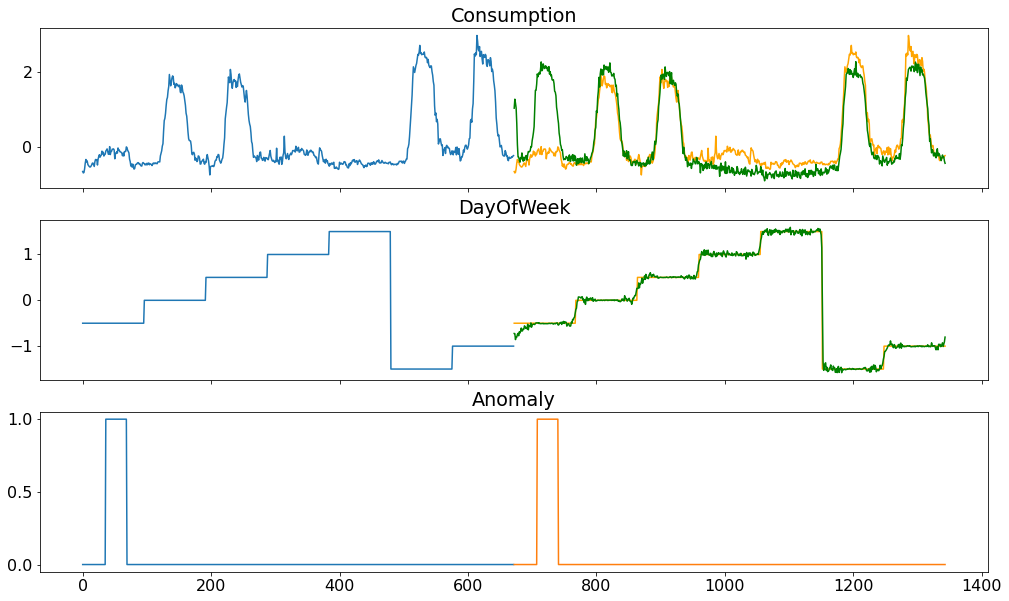

In [31]:
w = X_test[0,:,:] 
w = tf.expand_dims(w, 0)
_, _, encoded_data = encoder(w)
_, _, reconstruction = decoder(encoded_data) 
a = A_test[0,:]

# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

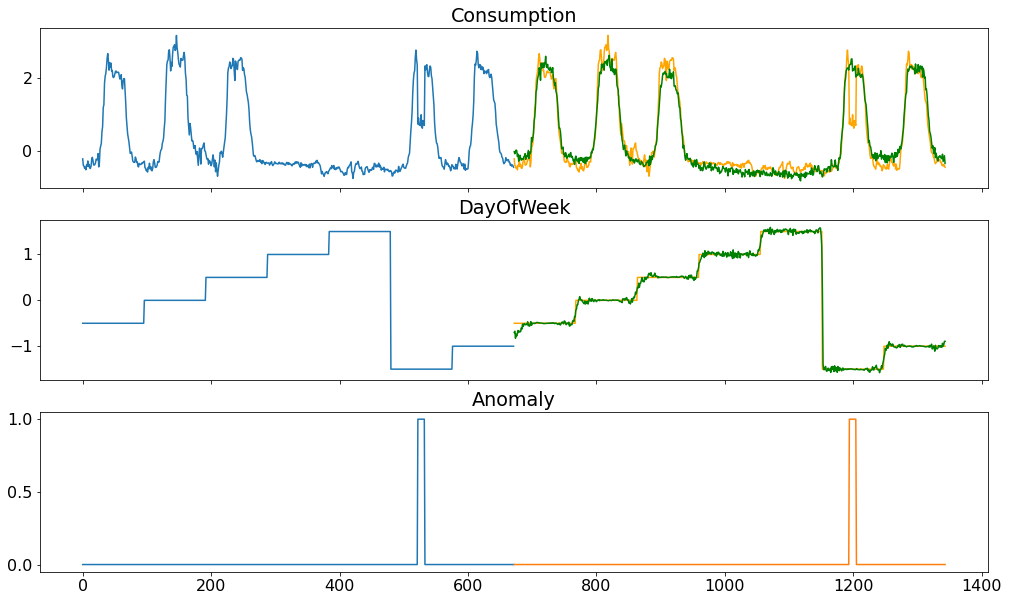

In [32]:
w = X_test[1,:,:] 
w = tf.expand_dims(w, 0)
_, _, encoded_data = encoder(w)
_, _, reconstruction = decoder(encoded_data) 
a = A_test[1,:]

# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

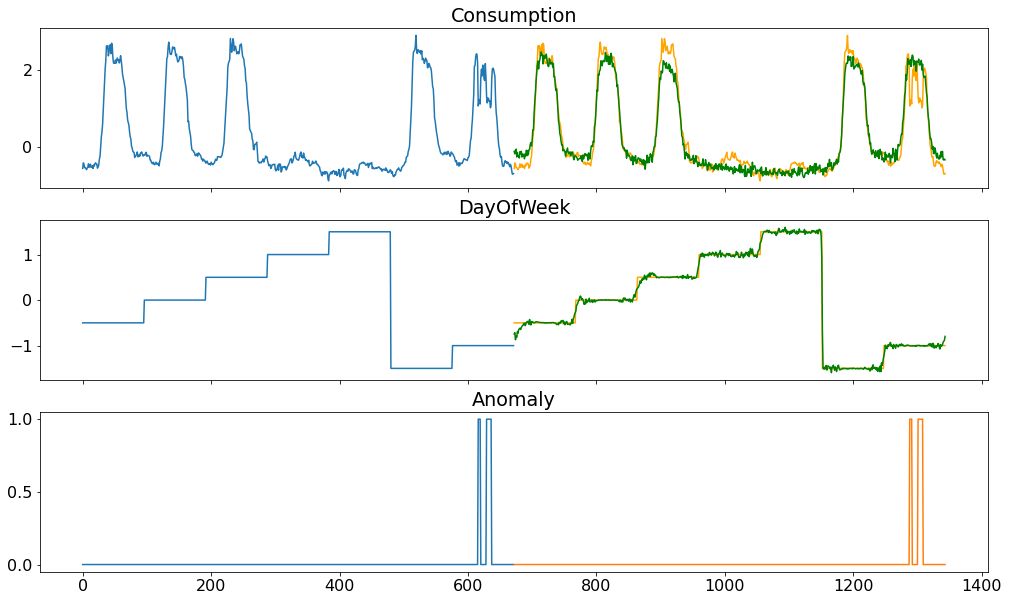

In [33]:
w = X_test[2,:,:] 
w = tf.expand_dims(w, 0)
_, _, encoded_data = encoder(w)
_, _, reconstruction = decoder(encoded_data) 
a = A_test[2,:]

# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

## Computing reconstruction probability

In [34]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride
    print("PADDING: " +  str(padding_len))

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [35]:
test_weeks = [0,1,2,3,4,12,17,18,19,39,51] # Weeks that are in the test set
indexes = [0,5,6,9,10] # Considering positions in "text_weeks", indexes of weeks to be considered on alone (non consecutive)
full_seq_index = [] # Tells us which windows of X_Test_Overlapped have to be fully considered (for all the other windows we will consider last "stride" elements)

counter = 0 # Tells us which window of X_Test_Overlapped we're considering

X_test_overlapped = np.empty(shape=(0, 672, 2))

for i in range(len(indexes)): # For all windows to be considered on alone ...
    
    # Interval of consecutive weeks to be considered
    left = indexes[i]
    if i+1 < len(indexes):
        right = indexes[i+1]
    else:
        right = indexes[-1] + 1
    
    full_seq_index.append(counter)
    df = X_test_raw.iloc[(left)*672:(right)*672].copy()
    dataset = build_sequences_reconstruction(df, window, stride) # Creating sequences using consecutive weeks we have identified
    counter = counter + dataset.shape[0]
    X_test_overlapped = np.concatenate((X_test_overlapped, dataset[:,:,:2]), axis=0) # We concatenate new windows created
        
X_test_overlapped.shape, full_seq_index

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1013, 672, 2), [0, 673, 674, 1011, 1012])

In [36]:
reconstructed_prob = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
reconstructed_prob_written = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
new_start = 0

for j in range (X_test_overlapped.shape[0]): # Consider all the windows in X_test_overlapped one at a time ...
    
    if(True): print(j)
    
    w = X_test_overlapped[j,:,:] 
    w = tf.expand_dims(w, 0)
    
    _, _, encoded_data = encoder(w) # Sampling only 1 time in the latent space
    
    if j in full_seq_index:
        
        for m in range(M):
            
            decoder_mu, decoder_log_var, _ = decoder(encoded_data)
            decoder_sigma = tf.exp(alpha * decoder_log_var)
            
            for i in range(window):  
                pdf_normal = tfp.distributions.MultivariateNormalDiag(decoder_mu[0, i, :-1], np.diag(decoder_sigma[0, i, :-1]), validate_args=True, name='Gauss')
                p_l = -(pdf_normal.log_prob(X_test_overlapped[j, i, :-1]))             
                reconstructed_prob[new_start+i] = reconstructed_prob[new_start+i] + p_l
                reconstructed_prob_written[new_start+i] = reconstructed_prob_written[new_start+i] + 1
                
        new_start = new_start+window
        
    else:
        
        for m in range(M):
            
            decoder_mu, decoder_log_var, _ = decoder(encoded_data)
            decoder_sigma = tf.exp(alpha * decoder_log_var)
            
            for i in range(stride):
                pdf_normal = tfp.distributions.MultivariateNormalDiag(decoder_mu[0, window-stride+i, :-1], np.diag(decoder_sigma[0, window-stride+i, :-1]), validate_args=True, name='Gauss')
                p_l = -(pdf_normal.log_prob(X_test_overlapped[j, window-stride+i, :-1]))   
                if new_start+i < X_test_raw.shape[0]: # To avoid problems related to padding
                    reconstructed_prob[new_start+i] = reconstructed_prob[new_start+i] + p_l
                    reconstructed_prob_written[new_start+i] = reconstructed_prob_written[new_start+i] + 1
                    
        new_start = new_start + stride
        
reconstructed_prob /= M
reconstructed_prob.shape, reconstructed_prob.max(), reconstructed_prob.min()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

((7392,), 507.58887, -1.9440472)

In [37]:
reconstructed_prob_written.sum(), X_test_raw.shape[0]

(73920.0, 7392)

In [38]:
# Checking if we've written correct things inside "reconstruction_prob"
check = True
for i in range(reconstructed_prob_written.shape[0]):
    if reconstructed_prob_written[i] != M: # Each cell written M times
        check = False
        
print(check) # If true, everything okay

True


In [39]:
# Counting the number of elements in "reconstructed_prob" that are equal to 0
counter = 0
for i in range(reconstructed_prob.shape[0]):
    if reconstructed_prob[i] == 0:
        counter += 1
        
print(counter)

0


In [40]:
w = X_test_overlapped[0,:,:]
z_mu, z_log_var, z = encoder(np.expand_dims(w, axis=0))
print(tf.exp(alpha * z_log_var))
d_mu, d_log_var, decoder_output = decoder(z)
print(tf.exp(alpha * d_log_var))

tf.Tensor(
[[0.1181283  0.44557223 0.00262124 0.97940075 0.98215854 0.9683848
  0.97123754 0.9677041  0.97396994 0.96635693]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[[0.07117727 0.03715617]
  [0.07132702 0.04410343]
  [0.07319501 0.03856403]
  ...
  [0.07230218 0.03963709]
  [0.07231239 0.03890125]
  [0.07163286 0.01803662]]], shape=(1, 672, 2), dtype=float32)


In [41]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_probabilities, threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=X_test_raw.shape[0])
    
    for i in range(reconstruction_probabilities.shape[0]): 
        if reconstruction_probabilities[i] > threshold:
            anomaly_predicted[i] = 1
            
    return anomaly_predicted

In [42]:
def select_best_threshold(reconstructed_prob, step, anomaly_true):
    
    min_prob = 0
    max_prob = reconstructed_prob.max()
    max_F1 = 0
    best_threshold = 0
    counter = 0
    
    print("best threshold = " + str(best_threshold) + ", max F1 = " + str(max_F1))
    
    thresholds = [x for x in np.arange(min_prob, max_prob, step)]
    
    for threshold in thresholds:
        
        # print("Trying threshold: " + str(threshold))
        
        if(counter<1000):
            
            anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)
            f1 = f1_score(y_true=anomaly_true, y_pred=anomaly_predicted)
            if f1 >= max_F1:
                max_F1 = f1
                best_threshold = threshold
                print("best threshold =" + str(best_threshold) + ", max F1 = " + str(max_F1))
            else:
                counter = counter+1
        
        else:
            return best_threshold

In [43]:
step = 1/10
threshold = select_best_threshold(reconstructed_prob, step, Anomaly_Test)
anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)

threshold, anomaly_predicted.sum(), anomaly_predicted.shape

best threshold = 0, max F1 = 0
best threshold =0.0, max F1 = 0.17679294734334047
best threshold =0.1, max F1 = 0.18044747081712062
best threshold =0.2, max F1 = 0.1832551247221536
best threshold =0.30000000000000004, max F1 = 0.18596491228070175
best threshold =0.4, max F1 = 0.18914096354830487
best threshold =0.5, max F1 = 0.19217819217819218
best threshold =0.6000000000000001, max F1 = 0.19567510548523206
best threshold =0.7000000000000001, max F1 = 0.19813084112149532
best threshold =0.8, max F1 = 0.2016852405544985
best threshold =0.9, max F1 = 0.205085682697623
best threshold =1.0, max F1 = 0.20836843583263126
best threshold =1.1, max F1 = 0.212
best threshold =1.2000000000000002, max F1 = 0.21482339316734222
best threshold =1.3, max F1 = 0.21829949985289793
best threshold =1.4000000000000001, max F1 = 0.22089907710628165
best threshold =1.5, max F1 = 0.2228228228228228
best threshold =1.6, max F1 = 0.22581629539212694
best threshold =1.7000000000000002, max F1 = 0.228606734630831

(144.8, 328.0, (7392,))

In [44]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)
Anomaly_Test

,Anomaly
0,0
1,0
2,0
3,0
4,0
...,...
7387,0
7388,0
7389,0
7390,0


In [45]:
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted'] = anomaly_predicted 
X_test_raw['Reconstruction_Probability'] = reconstructed_prob
X_test_raw.head()

,Consumption,DayOfWeek,Anomaly_Label_GT,Anomaly_Predicted,Reconstruction_Probability
0,-0.660426,-0.499988,0,0.0,24.550219
1,-0.699319,-0.499988,0,0.0,15.830343
2,-0.685176,-0.499988,0,0.0,23.807175
3,-0.586177,-0.499988,0,0.0,19.065672
4,-0.434142,-0.499988,0,0.0,4.338555


In [46]:
X_test_raw['Anomaly_Label_GT']

0       0
1       0
2       0
3       0
4       0
       ..
7387    0
7388    0
7389    0
7390    0
7391    0
Name: Anomaly_Label_GT, Length: 7392, dtype: int64

In [47]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [48]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted, reconstruction_prob, columns): 
   
    figs, axs = plt.subplots(4, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:1]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange')  
        axs[i].set_title(col) 
                 
    axs[1].plot(np.arange(len(X[:,i])), a_true) 
    axs[1].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[1].set_title('Anomaly_Label_GT') 
    
    axs[2].plot(np.arange(len(X[:,i])), a_predicted) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted) 
    axs[2].set_title('Anomaly_Predicted')
    
    axs[3].plot(np.arange(len(X[:,i])), reconstruction_prob) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), reconstruction_prob) 
    axs[3].set_title('Reconstrution_Probability') 
    plt.show()

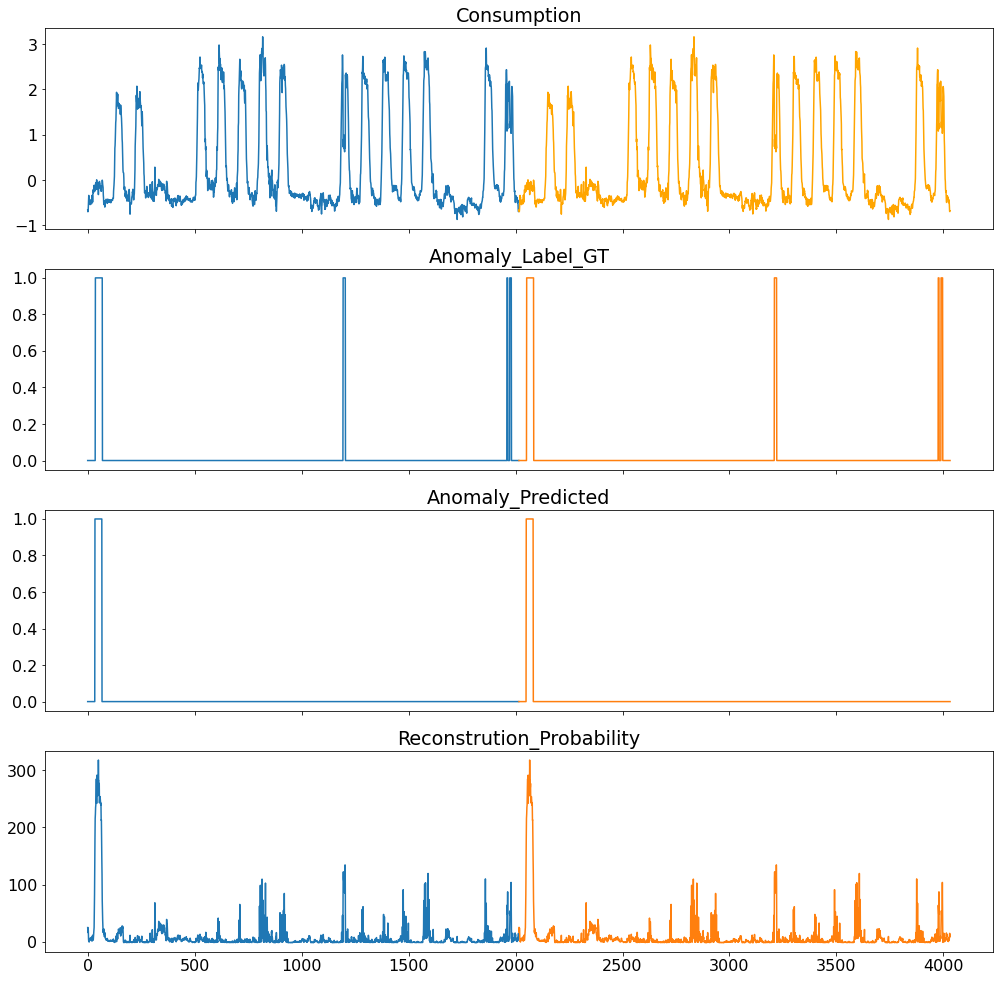

In [49]:
import datetime as dt

i=0
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

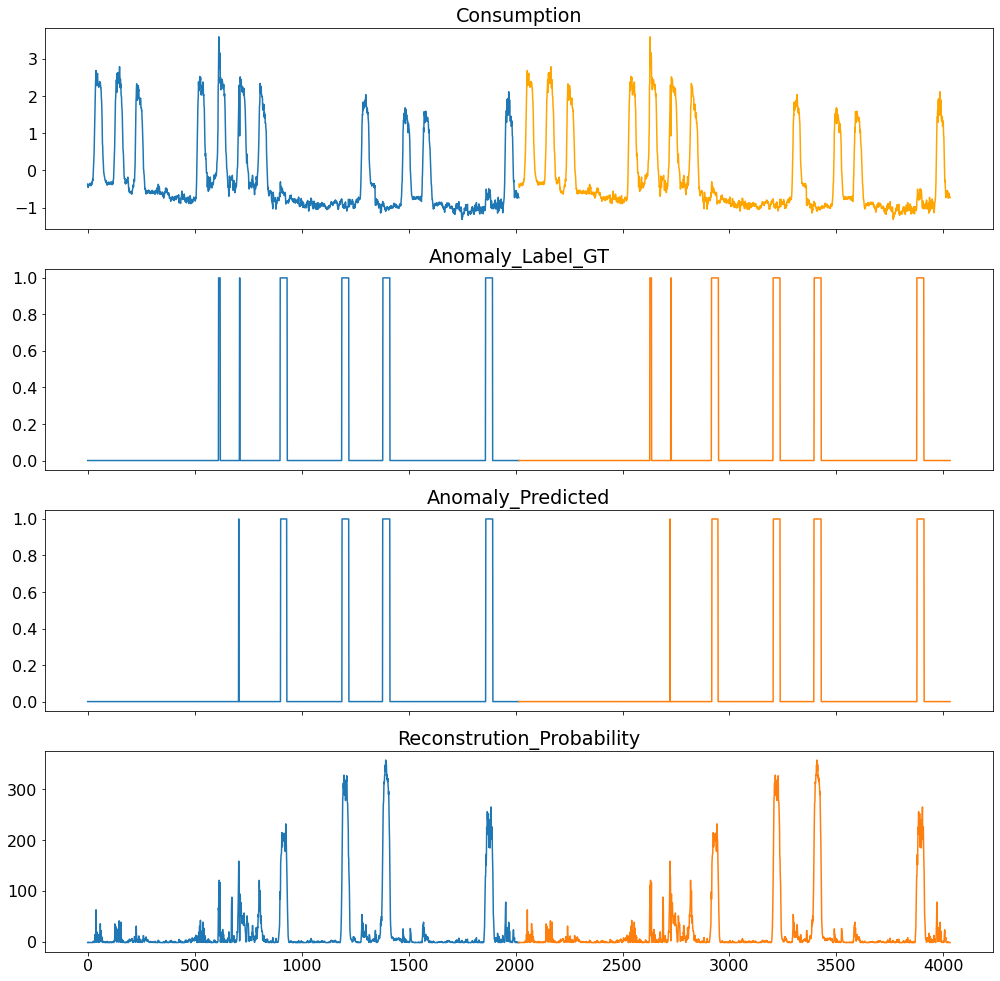

In [50]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

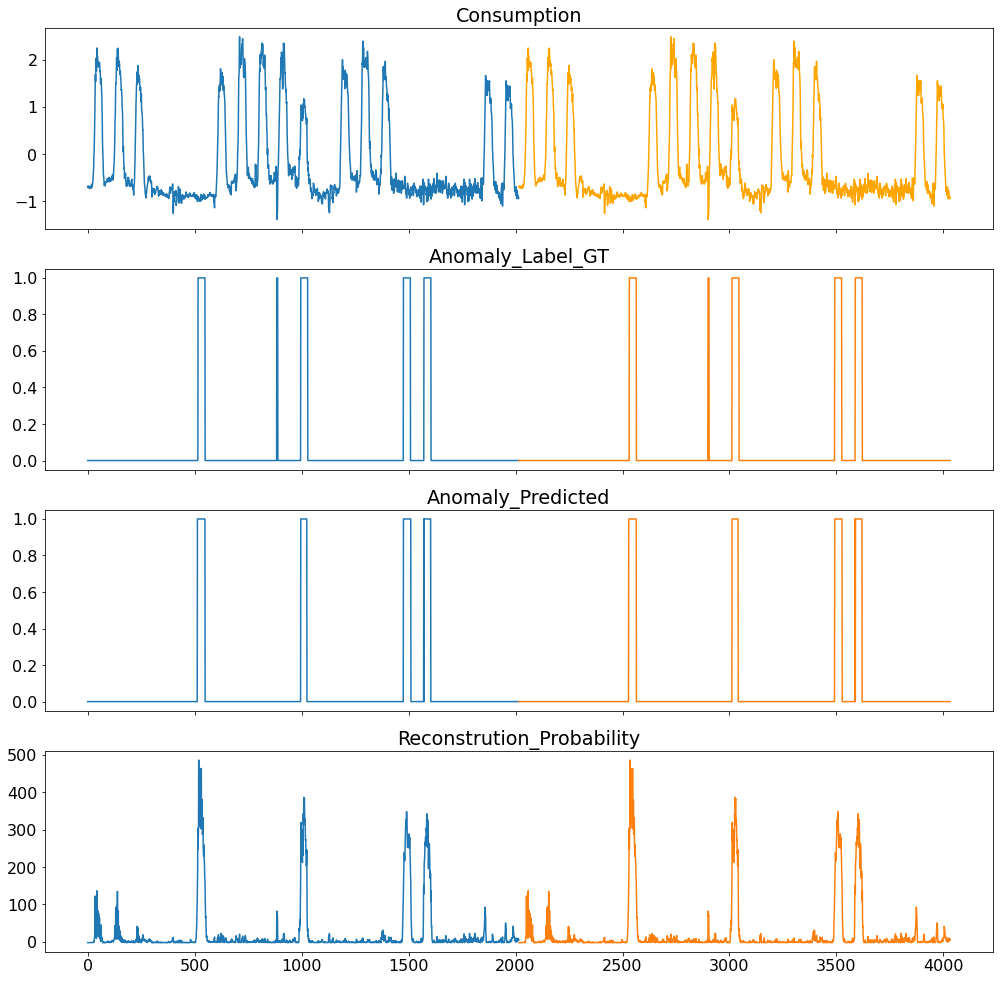

In [51]:
import datetime as dt

i=8
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

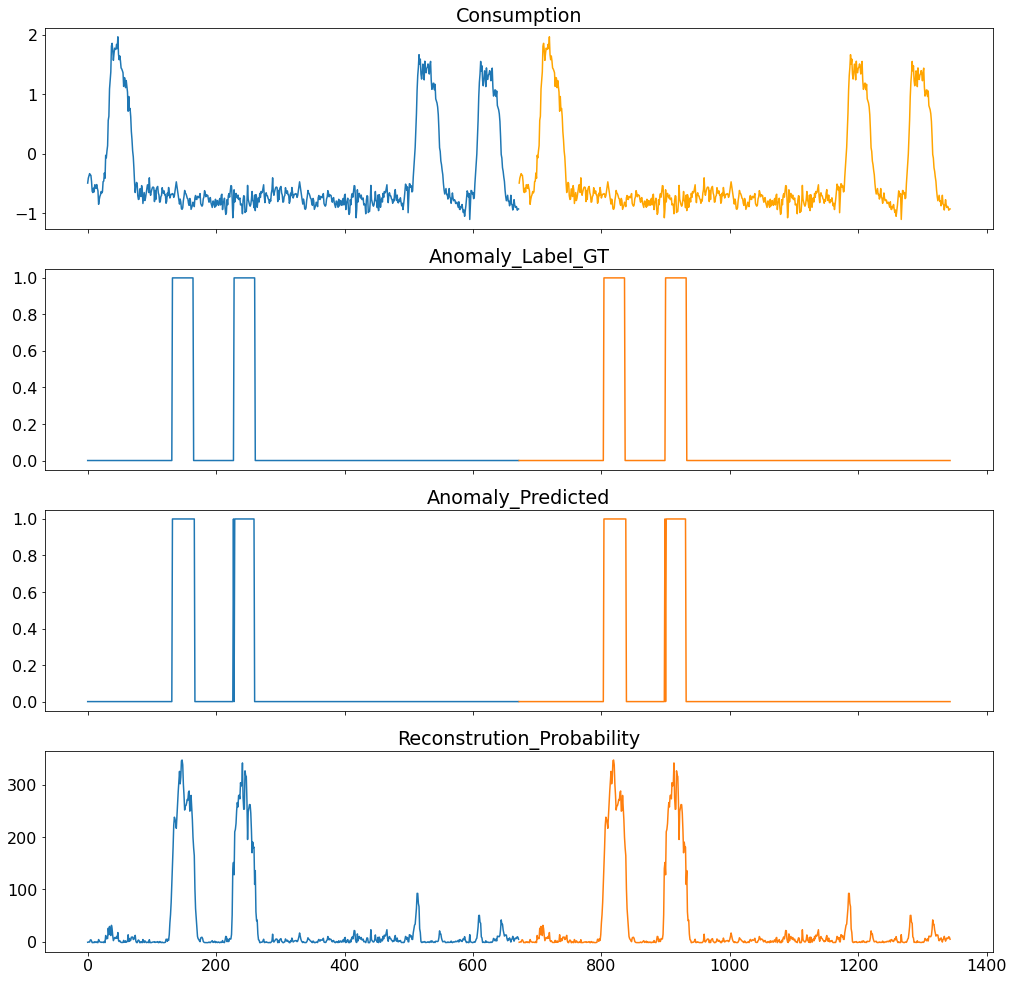

In [52]:
import datetime as dt

i=10
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

Accuracy: 0.9907
Precision: 0.9604
Recall: 0.8491
F1: 0.9013


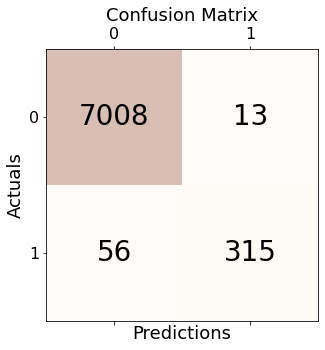

In [53]:
anomaly_predicted = anomaly_predicted

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()